In [1]:
### Author: Andrea Mastropietro © All rights reserved ###

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn.conv import SAGEConv
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.utils import k_hop_subgraph

import numpy as np
import random

import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

from src.utils import GDADataset

### Set Random Seeds

In [2]:
SEED = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
# torch.backends.cudnn.deterministic = True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Working on device: ", device)

Working on device:  cuda


### Data Preparation

In [4]:
G = nx.read_gml("data/gene_disease_association_data/graph_C0006142.gml")
seed_genes = pd.read_csv("data/gene_disease_association_data/C0006142_seed_genes.txt", header=None, sep=' ')

seed_genes.columns  = ["name", "GDA Score"]
display(seed_genes.head())

name  GDA Score
0   NAT2       0.40
1  ABCA3       0.30
2  ABCA4       0.33
3   ABL1       0.40
4  ACADM       0.31

In [5]:
seeds_list = seed_genes["name"].values.tolist()

In [6]:
for node in G:
    print(node, G.nodes[node])

MAP2K4 {'degree': 52, 'ring': 1, 'NetRank': 0.3776224, 'NetShort': 6621.135, 'HeatDiff': 0.7857457, 'InfoDiff': 0.8043124}
FLNC {'degree': 149, 'ring': 2, 'NetRank': 1.904549, 'NetShort': 6874.44, 'HeatDiff': 0.05550523, 'InfoDiff': 0.05931604}
MYPN {'degree': 27, 'ring': 3, 'NetRank': 2.932246, 'NetShort': 255.5409, 'HeatDiff': 0.0007826568, 'InfoDiff': 0.004238711}
ACTN2 {'degree': 129, 'ring': 2, 'NetRank': 1.932025, 'NetShort': 5092.236, 'HeatDiff': 0.03894884, 'InfoDiff': 0.04814739}
ACVR1 {'degree': 58, 'ring': 1, 'NetRank': 0.4443574, 'NetShort': 6898.941, 'HeatDiff': 0.7215197, 'InfoDiff': 0.7137646}
FNTA {'degree': 73, 'ring': 2, 'NetRank': 1.893177, 'NetShort': 6849.385, 'HeatDiff': 0.02677262, 'InfoDiff': 0.04000238}
GATA2 {'degree': 60, 'ring': 2, 'NetRank': 1.896108, 'NetShort': 7060.474, 'HeatDiff': 0.004525843, 'InfoDiff': 0.02046503}
PML {'degree': 311, 'ring': 2, 'NetRank': 1.872093, 'NetShort': 7307.018, 'HeatDiff': 0.08472546, 'InfoDiff': 0.1096246}
RPA2 {'degree': 5

In [7]:
labels = []

for node in G:
    if node in seeds_list:
        labels.append(0)
    else:
        labels.append(1)


In [8]:
features_names = ['degree', 'ring', 'NetRank', 'NetShort', 'HeatDiff', 'InfoDiff']
dataset = GDADataset(G, labels, features_names, num_classes=2)[0] #we have a single graph

In [9]:
dataset

Data(edge_index=[2, 1357864], x=[19761, 6], y=[19761], num_classes=2, train_mask=[19761], test_mask=[19761], val_mask=[19761])

### Define and Load GNN model

In [10]:
class GraphSAGE(nn.Module):
    def __init__(self, data, hidden_channels=16):
        super().__init__()
        self.conv1 = SAGEConv(data.num_features, hidden_channels, aggr='max')
        self.conv2 = SAGEConv(hidden_channels, hidden_channels, aggr='max')
        self.conv3 = SAGEConv(hidden_channels, hidden_channels, aggr='max')
        self.conv4 = SAGEConv(hidden_channels, hidden_channels, aggr='max')
        self.conv5 = SAGEConv(hidden_channels, hidden_channels, aggr='max')
        self.conv6 = SAGEConv(hidden_channels, hidden_channels, aggr='max')
        self.conv7 = SAGEConv(hidden_channels, int(data.num_classes), aggr='max')
    
    def forward(self, x, edge_index):

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x = F.relu(self.conv5(x, edge_index))
        x = F.relu(self.conv6(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv7(x, edge_index)

        return F.log_softmax(x, dim=1)

In [11]:
model = GraphSAGE(dataset, hidden_channels=16)
dataset = dataset.to(device)
model = model.to(device)

model.load_state_dict(torch.load("models/graphsage_gnn_model.ckpt", map_location=torch.device(device)))
model.eval()

output = model(dataset.x, dataset.edge_index)
preds = output.argmax(1)
preds

tensor([0, 1, 1,  ..., 1, 1, 1], device='cuda:0')

### Use GNNExplainer to explain the predictions of gene BRCA1 (known associated gene) 

In [12]:
gene_names = list(G.nodes())
gene_index = gene_names.index("BRCA1")
print("BRCA1 prediction: ", preds[gene_index].item())

BRCA1 prediction:  0


Generated explanations in ['node_mask', 'edge_mask']


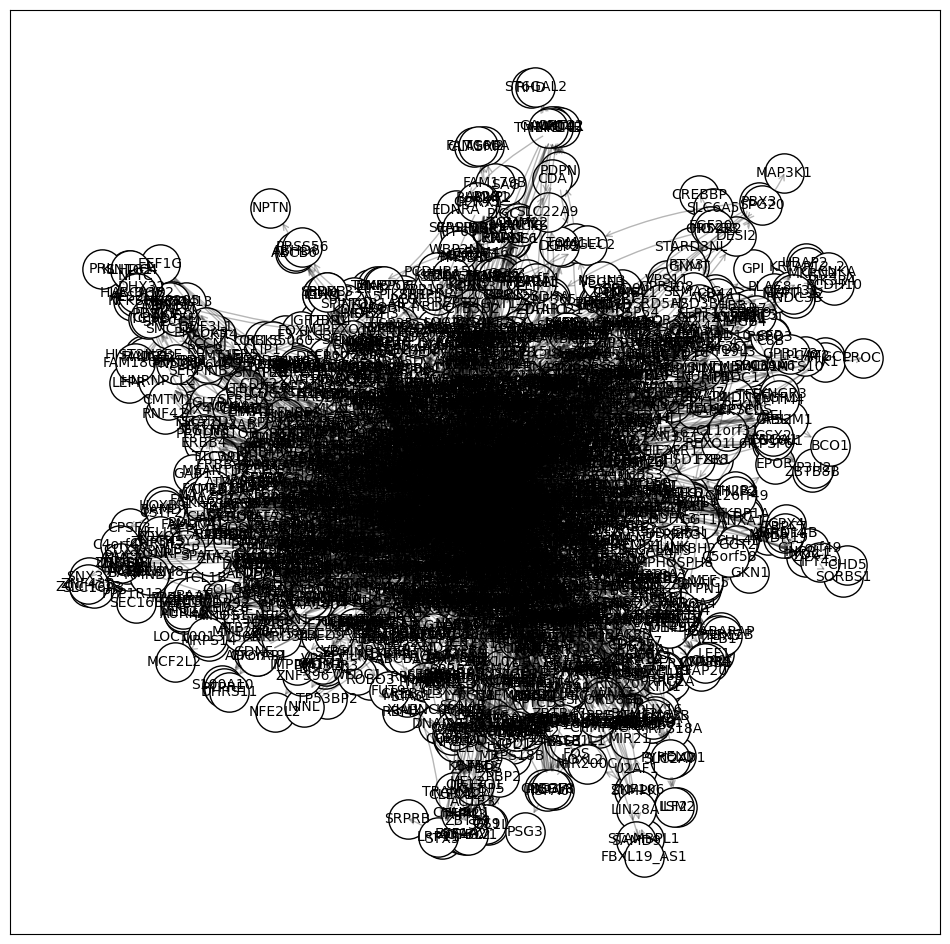

Subgraph visualization plot has been saved to 'results/gene_disease_prioritization_gnnexplainer/explanation_subgraph.png'


In [13]:
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='object', #attributes, common_attributes, object
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
    
)


explanation = explainer(dataset.x, dataset.edge_index, index=gene_index)
print(f'Generated explanations in {explanation.available_explanations}')

path = 'results/gene_disease_prioritization_gnnexplainer/explanation_subgraph.png'

plt.figure(figsize=(12, 12))
explanation.visualize_graph(path=None, backend="networkx", node_labels=gene_names)
plt.figure(figsize=(12, 12))
explanation.visualize_graph(path=path, backend="networkx", node_labels=gene_names)
print(f"Subgraph visualization plot has been saved to '{path}'")

### Explaining only in the 1-hop subgraph

In [14]:
subgraph_nodes, subgraph_edge_index, new_gene_index, _ = k_hop_subgraph(gene_index, 1, dataset.edge_index, relabel_nodes=True)
subgraph_nodes_list = subgraph_nodes.cpu().numpy().tolist()

#sublist containing gene names from sugraph nodes
subgraph_gene_names = [gene_names[i] for i in subgraph_nodes_list]
subgraph_gene_names

['FLNC',
 'FNTA',
 'PML',
 'RPA2',
 'ALDOA',
 'TFAP2A',
 'EP300',
 'BARD1',
 'GIPC1',
 'BRCA1',
 'ATF1',
 'MSH2',
 'MSH6',
 'TTN',
 'ITPR1',
 'CTNNB1',
 'RB1',
 'MCM2',
 'MCM5',
 'ORC2',
 'DBF4',
 'AKAP8',
 'RPA1',
 'RPA3',
 'MCM3',
 'YWHAZ',
 'CDKN3',
 'CDK2',
 'RBBP8',
 'RBL1',
 'CENPB',
 'CLTC',
 'COL1A1',
 'SMAD3',
 'CCNB1',
 'DCN',
 'SIM2',
 'ARNT',
 'PCNA',
 'TOPBP1',
 'FLNA',
 'EGR1',
 'CREBBP',
 'NUMA1',
 'EEF1D',
 'ANXA5',
 'ESR1',
 'SMARCA4',
 'DDX54',
 'SUMO1',
 'HSPA5',
 'KPNA2',
 'GRN',
 'UBE2I',
 'EIF3E',
 'GANAB',
 'HNRNPA1',
 'HNRNPM',
 'MAN2C1',
 'UBAP2L',
 'QARS',
 'YWHAQ',
 'YWHAE',
 'JAK2',
 'PRMT5',
 'KRT18',
 'LMNA',
 'LMNB1',
 'BCL2',
 'BECN1',
 'XRCC6',
 'XRCC5',
 'MRE11A',
 'CBX5',
 'PIAS4',
 'YBX1',
 'ORC3',
 'FHL2',
 'PFN1',
 'RELA',
 'NOP2',
 'MCRS1',
 'ETS1',
 'AKT1',
 'EZH2',
 'TLE4',
 'PGD',
 'HUS1',
 'MAPK1',
 'GNB2L1',
 'AR',
 'BRCA2',
 'RAD51',
 'AATF',
 'RBL2',
 'RPS25',
 'RPLP1',
 'RPLP2',
 'OBSCN',
 'NRIP1',
 'ARFGEF1',
 'NCAPG2',
 'KAT5',
 'E2F1',


In [15]:
subgraph_features = dataset.x[subgraph_nodes_list]

Generated explanations in ['node_mask', 'edge_mask']


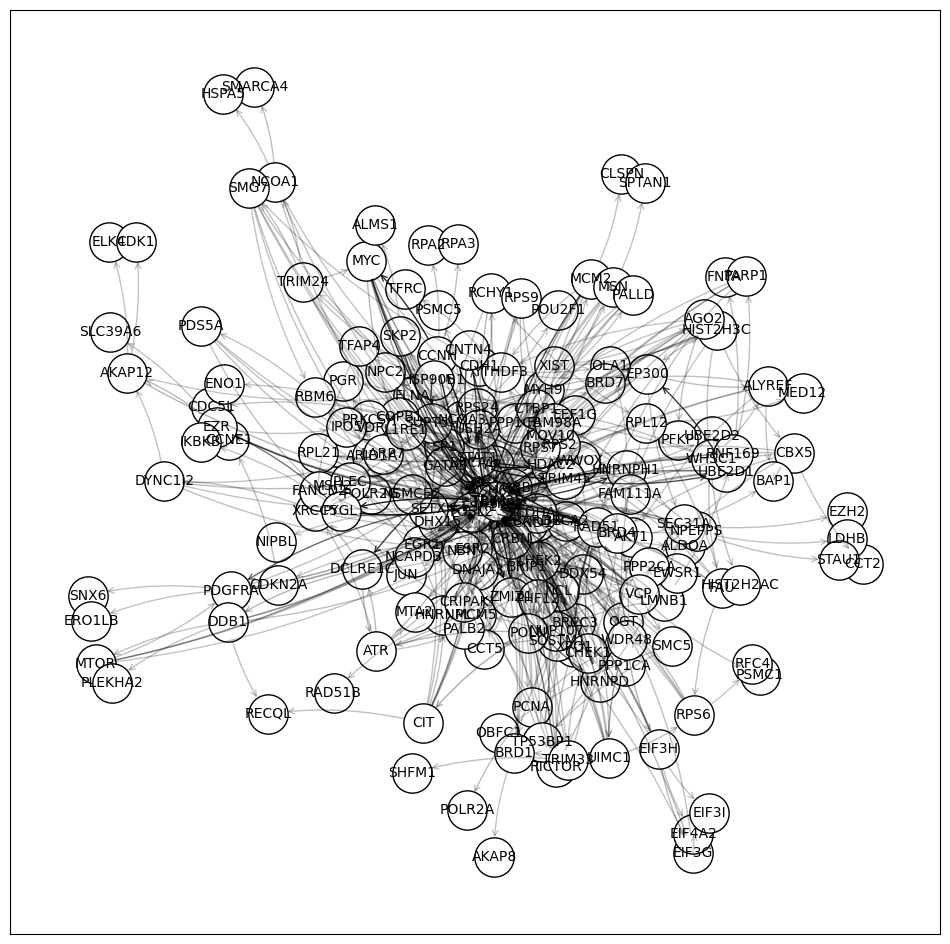

Subgraph visualization plot has been saved to 'results/gene_disease_prioritization_gnnexplainer/explanation_subgraph_1_hop.png'


In [16]:
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='object',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
    
)

explanation = explainer(subgraph_features, subgraph_edge_index, index=new_gene_index)
print(f'Generated explanations in {explanation.available_explanations}')

path = 'results/gene_disease_prioritization_gnnexplainer/explanation_subgraph_1_hop.png'

plt.figure(figsize=(12, 12))
explanation.visualize_graph(path=None, backend="networkx", node_labels=subgraph_gene_names)
plt.figure(figsize=(12, 12))
explanation.visualize_graph(path=path, backend="networkx", node_labels=subgraph_gene_names)
print(f"Subgraph visualization plot has been saved to '{path}'")

### Gather the top k edges for the explanation

Generated explanations in ['node_mask', 'edge_mask']


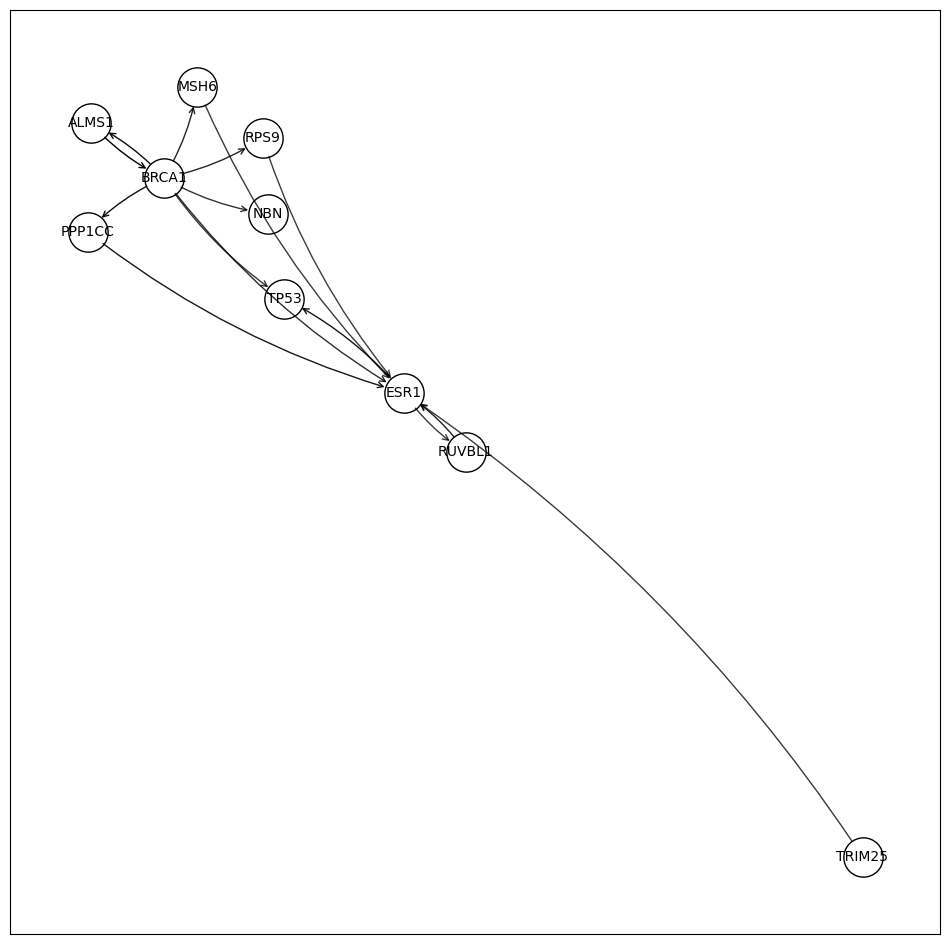

Subgraph visualization plot has been saved to 'results/gene_disease_prioritization_gnnexplainer/explanation_subgraph_1_hop_top_k.png'


In [17]:
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='object',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
    threshold_config = dict(
        threshold_type ='topk',
        value=15,
    ),
    
)

explanation = explainer(subgraph_features, subgraph_edge_index, index=new_gene_index)
print(f'Generated explanations in {explanation.available_explanations}')

path = 'results/gene_disease_prioritization_gnnexplainer/explanation_subgraph_1_hop_top_k.png'

plt.figure(figsize=(12, 12))
explanation.visualize_graph(path=None, backend="networkx", node_labels=subgraph_gene_names)
plt.figure(figsize=(12, 12))
explanation.visualize_graph(path=path, backend="networkx", node_labels=subgraph_gene_names)
print(f"Subgraph visualization plot has been saved to '{path}'")

### Node importance

In [18]:
node_importance = {}

for i, node in enumerate(subgraph_gene_names):
    node_importance[node] = explanation.node_mask[i].item()

node_ranking = sorted(node_importance.items(), key=lambda x: x[1], reverse=True)
display(node_ranking)

[('BRCA1', 0.5541920065879822),
 ('ESR1', 0.5025708675384521),
 ('TP53', 0.49202269315719604),
 ('RUVBL1', 0.36660897731781006),
 ('ALMS1', 0.34244662523269653),
 ('MORF4L1', 0.3205481469631195),
 ('MSH6', 0.29347512125968933),
 ('SUPT16H', 0.2765534818172455),
 ('NBN', 0.27611270546913147),
 ('THOC3', 0.27364686131477356),
 ('SMTN', 0.2699899673461914),
 ('ODF2', 0.2612159252166748),
 ('PCBP2', 0.24093320965766907),
 ('L1RE1', 0.23748140037059784),
 ('AKT1', 0.2349141389131546),
 ('FLNC', 0.0),
 ('FNTA', 0.0),
 ('PML', 0.0),
 ('RPA2', 0.0),
 ('ALDOA', 0.0),
 ('TFAP2A', 0.0),
 ('EP300', 0.0),
 ('BARD1', 0.0),
 ('GIPC1', 0.0),
 ('ATF1', 0.0),
 ('MSH2', 0.0),
 ('TTN', 0.0),
 ('ITPR1', 0.0),
 ('CTNNB1', 0.0),
 ('RB1', 0.0),
 ('MCM2', 0.0),
 ('MCM5', 0.0),
 ('ORC2', 0.0),
 ('DBF4', 0.0),
 ('AKAP8', 0.0),
 ('RPA1', 0.0),
 ('RPA3', 0.0),
 ('MCM3', 0.0),
 ('YWHAZ', 0.0),
 ('CDKN3', 0.0),
 ('CDK2', 0.0),
 ('RBBP8', 0.0),
 ('RBL1', 0.0),
 ('CENPB', 0.0),
 ('CLTC', 0.0),
 ('COL1A1', 0.0),
 ('SMA

### Feature importance

In [19]:
#determine feature importance of each feature in each node
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
    
)

explanation = explainer(subgraph_features, subgraph_edge_index, index=new_gene_index)
print(f'Generated explanations in {explanation.available_explanations}')


Generated explanations in ['node_mask', 'edge_mask']


In [22]:
explanation.node_mask

tensor([[0.1441, 0.1652, 0.1440, 0.1621, 0.1686, 0.1351],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        ...,
        [0.1439, 0.1360, 0.1245, 0.3206, 0.1202, 0.1470],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]], device='cuda:0')

In [23]:
explanation.node_mask[new_gene_index]

tensor([[0.1659, 0.1412, 0.1592, 0.5413, 0.1366, 0.1443]], device='cuda:0')

In [24]:
#determine feature importance across all nodes
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='common_attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
    
)

explanation = explainer(subgraph_features, subgraph_edge_index, index=new_gene_index)
print(f'Generated explanations in {explanation.available_explanations}')

Generated explanations in ['node_mask', 'edge_mask']


In [26]:
explanation.node_mask

tensor([[0.1493, 0.1480, 0.1226, 0.2314, 0.1249, 0.1424]], device='cuda:0')